# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'
    
models_path = utils.get_m5_root_dir() + '/models/'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 34)
(44307636, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.125)
    hess = np.where(residual < 0, 2, 2 * 1.125)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.125)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:


params_cat_id_2 = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed': 10,
    'learning_rate': 0.25,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^9,
}

In [9]:


  # to record eval results for plotting


for cat in df_merged.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    evals_result = {}
    start = time.time()
    
    if cat == 0:
        params = params_cat_id_2
    elif cat == 1:
        params = params_cat_id_2
    elif cat == 2:
        params = params_cat_id_2
    else:
        raise ValueError(f'Cat_id not in [0,1,2].')
    
    print('log: create data sets')
    x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    x_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    print('log: create LightGBM data sets')
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )

    print('log: model training')
    gbm= lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                    fobj=custom_mse_asymmetric_loss,
                    feval = custom_rmse_asymmetric_valid
                   )
    
    
    print('log: save model and evals result')
    gbm.save_model(f'{models_path}gbm_cat_id_{cat}_{prefix}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    print('\n Training for cat_id %s took %0.2f minutes.' %(cat, (time.time()-start)/60))




 ***** Computation for cat_id  1 *****
log: create data sets
log: create LightGBM data sets
log: model training


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 1.7889	training's custom_mse_asymmetric_eval: 1.87194	valid_1's rmse: 1.66436	valid_1's custom_mse_asymmetric_eval: 1.73975
Early stopping, best iteration is:
[20]	training's rmse: 1.79193	training's custom_mse_asymmetric_eval: 1.87554	valid_1's rmse: 1.66329	valid_1's custom_mse_asymmetric_eval: 1.73914
log: save model and evals result

 Training for cat_id 1 took 2.92 minutes.

 ***** Computation for cat_id  2 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 1.58556	training's custom_mse_asymmetric_eval: 1.65087	valid_1's rmse: 1.4837	valid_1's custom_mse_asymmetric_eval: 1.54192
[50]	training's rmse: 1.56741	training's custom_mse_asymmetric_eval: 1.63156	valid_1's rmse: 1.48061	valid_1's custom_mse_asymmetric_eval: 1.53745
Early stopping, best iteration is:
[54]	training's rmse: 1.56527	tra

 ***** Computation for cat_id  1 *****
log: create data sets
log: create LightGBM data sets
log: model training
c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.87791	valid_1's custom_mse_asymmetric_eval: 1.73294
[50]	training's custom_mse_asymmetric_eval: 1.85992	valid_1's custom_mse_asymmetric_eval: 1.72279
[75]	training's custom_mse_asymmetric_eval: 1.85296	valid_1's custom_mse_asymmetric_eval: 1.72076
[100]	training's custom_mse_asymmetric_eval: 1.84837	valid_1's custom_mse_asymmetric_eval: 1.72117
Early stopping, best iteration is:
[82]	training's custom_mse_asymmetric_eval: 1.85165	valid_1's custom_mse_asymmetric_eval: 1.72053
log: save model and evals result

 Training for cat_id 1 took 3.20 minutes.

 ***** Computation for cat_id  2 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.63858	valid_1's custom_mse_asymmetric_eval: 1.53228
[50]	training's custom_mse_asymmetric_eval: 1.61879	valid_1's custom_mse_asymmetric_eval: 1.5228
[75]	training's custom_mse_asymmetric_eval: 1.60555	valid_1's custom_mse_asymmetric_eval: 1.51907
[100]	training's custom_mse_asymmetric_eval: 1.59593	valid_1's custom_mse_asymmetric_eval: 1.51662
Early stopping, best iteration is:
[100]	training's custom_mse_asymmetric_eval: 1.59593	valid_1's custom_mse_asymmetric_eval: 1.51662
log: save model and evals result

 Training for cat_id 2 took 4.99 minutes.

 ***** Computation for cat_id  0 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 3.785	valid_1's custom_mse_asymmetric_eval: 2.89404
[50]	training's custom_mse_asymmetric_eval: 3.64886	valid_1's custom_mse_asymmetric_eval: 2.8155
[75]	training's custom_mse_asymmetric_eval: 3.59211	valid_1's custom_mse_asymmetric_eval: 2.79472
[100]	training's custom_mse_asymmetric_eval: 3.5517	valid_1's custom_mse_asymmetric_eval: 2.78793
[125]	training's custom_mse_asymmetric_eval: 3.52203	valid_1's custom_mse_asymmetric_eval: 2.78208
[150]	training's custom_mse_asymmetric_eval: 3.49799	valid_1's custom_mse_asymmetric_eval: 2.77928
[175]	training's custom_mse_asymmetric_eval: 3.47826	valid_1's custom_mse_asymmetric_eval: 2.7753
[200]	training's custom_mse_asymmetric_eval: 3.46013	valid_1's custom_mse_asymmetric_eval: 2.76982
[225]	training's custom_mse_asymmetric_eval: 3.44633	valid_1's custom_mse_asymmetric_eval: 2.76313
[250]	training's custom_mse_asymmetric_eval: 3.43442	valid_1's custom_mse_asymmetric_eval: 2.75911
[275]	training's custom_mse_asymmetric_eval: 3.42052	valid_1's custom_mse_asymmetric_eval: 2.75911
[300]	training's custom_mse_asymmetric_eval: 3.40913	valid_1's custom_mse_asymmetric_eval: 2.75346
[325]	training's custom_mse_asymmetric_eval: 3.40019	valid_1's custom_mse_asymmetric_eval: 2.75262
[350]	training's custom_mse_asymmetric_eval: 3.39086	valid_1's custom_mse_asymmetric_eval: 2.75157
[375]	training's custom_mse_asymmetric_eval: 3.38131	valid_1's custom_mse_asymmetric_eval: 2.7485
[400]	training's custom_mse_asymmetric_eval: 3.37352	valid_1's custom_mse_asymmetric_eval: 2.74707
[425]	training's custom_mse_asymmetric_eval: 3.36505	valid_1's custom_mse_asymmetric_eval: 2.74534
[450]	training's custom_mse_asymmetric_eval: 3.35626	valid_1's custom_mse_asymmetric_eval: 2.74369
[475]	training's custom_mse_asymmetric_eval: 3.35109	valid_1's custom_mse_asymmetric_eval: 2.74336
[500]	training's custom_mse_asymmetric_eval: 3.34498	valid_1's custom_mse_asymmetric_eval: 2.7421
[525]	training's custom_mse_asymmetric_eval: 3.33794	valid_1's custom_mse_asymmetric_eval: 2.74023

In [10]:

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan


for cat in x_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_pred.loc[x_pred.cat_id == cat,'y_pred'] = mod.predict(x_pred.loc[x_pred.cat_id == cat][features])

    

# Training Analysis


 ***** Computation for cat_id  1 *****


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:7: UserWarning: more than one metric available, picking one to plot.
  import sys


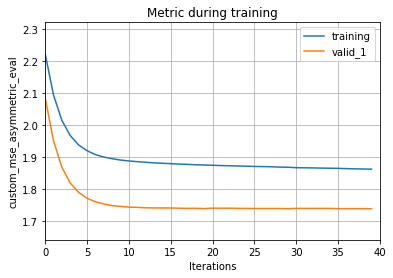

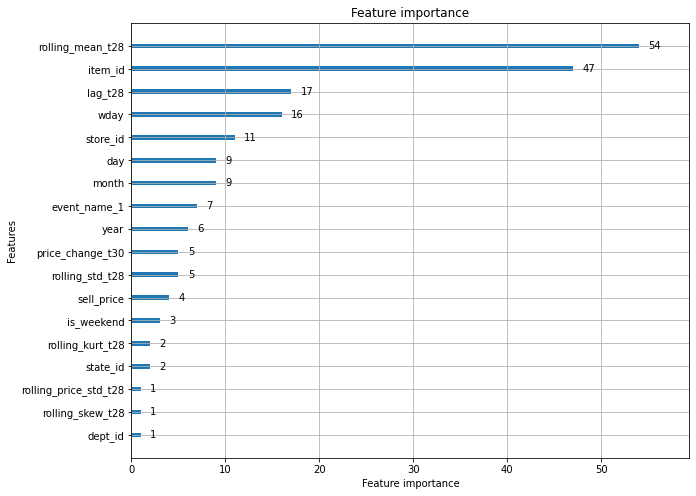


 ***** Computation for cat_id  2 *****


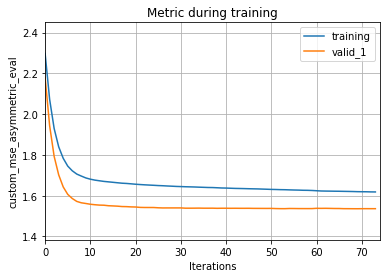

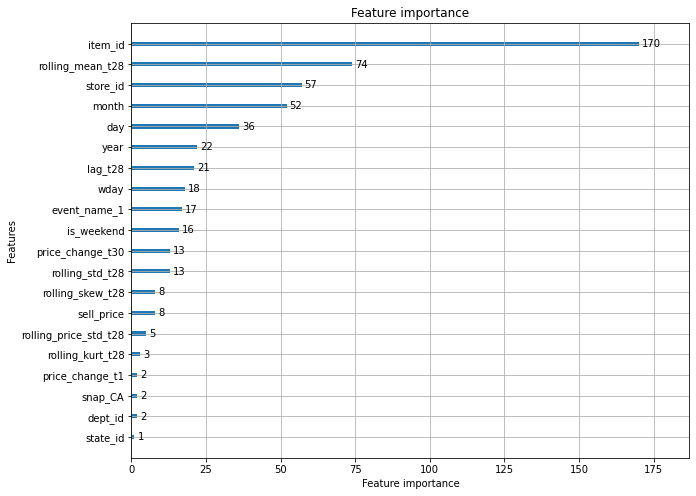


 ***** Computation for cat_id  0 *****


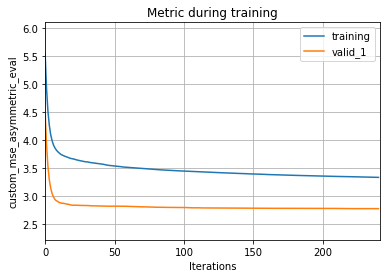

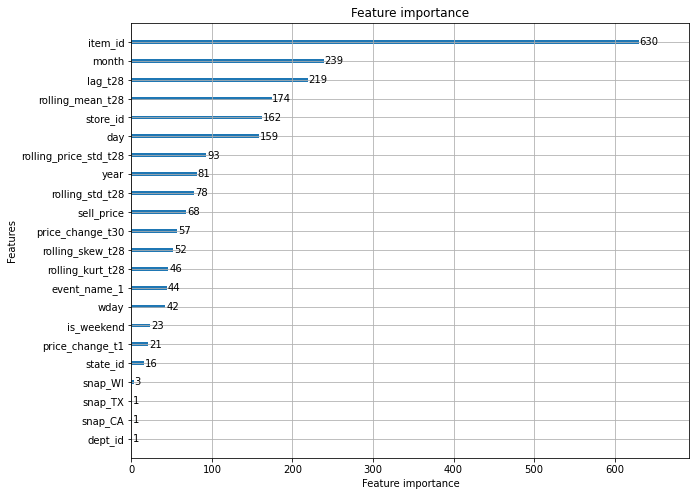

In [11]:
for cat in x_pred.cat_id.drop_duplicates():
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    evals = pickle.load(open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.show()
    


# Compute RMSSE and WRMSSE on Validation Data

In [12]:
# compute forecasts, error and map it to df_merged to get ids

# create validation set containing all categories
df_tmp = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
df_tmp['y_true'] = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27']['sale'].copy()

for cat in df_tmp.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    df_tmp.loc[df_tmp.cat_id == cat,'y_pred'] = mod.predict(df_tmp.loc[df_tmp.cat_id == cat][features])
    
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp.head(10)

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_true,y_pred,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.423363,1.000000,1.231763,0.0,0.0,8.622286e-08,1.0,0.893462,0.106538,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.310783,1.033333,1.245221,0.0,0.0,8.622286e-08,0.0,0.921781,-0.921781,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.893462,-0.893462,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.900913,-0.900913,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.992930,-0.992930,HOBBIES_1_001_CA_1_validation
5,1437,3,1,0,0,2016,4,2,1,1,...,1.356940,0.966667,1.272612,0.0,0.0,8.622286e-08,0.0,1.053809,-1.053809,HOBBIES_1_001_CA_1_validation
6,1437,3,1,0,0,2016,4,3,1,2,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,1.0,1.098722,-0.098722,HOBBIES_1_001_CA_1_validation
7,1437,3,1,0,0,2016,4,4,0,3,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.893462,-0.893462,HOBBIES_1_001_CA_1_validation
8,1437,3,1,0,0,2016,4,5,0,4,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,4.0,0.893462,3.106538,HOBBIES_1_001_CA_1_validation
9,1437,3,1,0,0,2016,4,6,0,5,...,1.444642,0.966667,1.245221,0.0,0.0,8.622286e-08,2.0,0.900913,1.099087,HOBBIES_1_001_CA_1_validation


In [13]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [14]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [15]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.88760


WRMSSE = 0.88675 -> one model per cat with custom loss and custom metric

In [16]:
# show RMSSE and corresponding weights
rmsse_df.sort_values(by='weights', ascending=False).head(20)

,RMSSE,id,weights,w_times_RMSSE
15906,0.844793,HOBBIES_1_158_TX_3_validation,0.003642,0.003077
17826,0.722465,HOBBIES_1_354_TX_3_validation,0.003544,0.002560
948,1.333728,FOODS_1_096_WI_2_validation,0.002928,0.003905
7322,1.106291,FOODS_3_120_CA_3_validation,0.002494,0.002759
17825,0.758609,HOBBIES_1_354_TX_2_validation,0.001698,0.001288
7320,1.073815,FOODS_3_120_CA_1_validation,0.001423,0.001528
17820,0.898294,HOBBIES_1_354_CA_1_validation,0.001416,0.001272
7468,1.103609,FOODS_3_134_WI_2_validation,0.001402,0.001548
7022,0.446863,FOODS_3_090_CA_3_validation,0.001319,0.000589
946,1.052586,FOODS_1_096_TX_3_validation,0.001309,0.001378


In [17]:
# analyse time series (manually)
rel_id = 'FOODS_1_096_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][[
    'id',
    'month',
    'day',
    'up_for_sale',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'is_weekend',
    'wday',
    'sell_price',
    'y_pred',
    'y_true',
    'error',
]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
730744,FOODS_1_096_WI_2_validation,3,28,1,13,1,3,1,0,3,7.23,45.282714,43.0,-2.282714
730745,FOODS_1_096_WI_2_validation,3,29,1,13,1,3,1,0,4,7.23,49.156462,50.0,0.843538
730746,FOODS_1_096_WI_2_validation,3,30,1,13,1,3,1,0,5,7.23,45.359403,50.0,4.640597
730747,FOODS_1_096_WI_2_validation,3,31,1,13,1,3,1,0,6,7.23,44.471749,48.0,3.528251
730748,FOODS_1_096_WI_2_validation,4,1,1,13,1,3,1,0,7,7.23,57.441466,82.0,24.558534
730749,FOODS_1_096_WI_2_validation,4,2,1,13,1,3,1,1,1,7.23,50.467443,52.0,1.532557
730750,FOODS_1_096_WI_2_validation,4,3,1,13,1,3,1,1,2,7.23,52.454555,44.0,-8.454555
730751,FOODS_1_096_WI_2_validation,4,4,1,13,1,3,1,0,3,7.23,55.940332,61.0,5.059668
730752,FOODS_1_096_WI_2_validation,4,5,1,13,1,3,1,0,4,7.23,41.090792,54.0,12.909208
730753,FOODS_1_096_WI_2_validation,4,6,1,13,1,3,1,0,5,7.23,48.889297,37.0,-11.889297


# Error for different Predicting Intervals

In [18]:
x_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
y_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']


x_val_pred['y_pred'] = np.nan


for cat in x_val_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_val_pred.loc[x_val_pred.cat_id == cat,'y_pred'] = mod.predict(x_val_pred.loc[x_val_pred.cat_id == cat][features])


In [19]:
x_val_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
51954960,1437,3,1,0,0,2016,3,28,0,3,...,8.26,0.0,1.165137,1.423363,1.000000,1.231763e+00,0.0,0.0,8.622286e-08,0.893462
51954961,1438,3,1,0,0,2016,3,28,0,3,...,3.97,0.0,2.859231,1.884415,0.166667,3.790490e-01,0.0,0.0,0.000000e+00,0.198580
51954962,1439,3,1,0,0,2016,3,28,0,3,...,2.97,0.0,-1.455547,0.919500,0.300000,4.660916e-01,0.0,0.0,0.000000e+00,0.297537
51954963,1440,3,1,0,0,2016,3,28,0,3,...,4.64,0.0,-0.455635,0.679141,2.200000,1.954659e+00,0.0,0.0,0.000000e+00,1.995461
51954964,1441,3,1,0,0,2016,3,28,0,3,...,2.88,1.0,1.330443,1.329091,1.133333,1.306043e+00,0.0,0.0,4.434852e-08,0.923656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52808675,1432,2,0,9,2,2016,4,24,1,2,...,2.98,0.0,4.439427,2.147972,0.266667,5.832923e-01,0.0,0.0,7.810822e-08,0.457481
52808676,1433,2,0,9,2,2016,4,24,1,2,...,2.48,0.0,NaN,NaN,0.000000,4.427322e-08,0.0,0.0,1.872101e-01,0.811158
52808677,1434,2,0,9,2,2016,4,24,1,2,...,3.98,1.0,-0.928225,0.038939,1.233333,9.352607e-01,0.0,0.0,0.000000e+00,1.247955
52808678,1435,2,0,9,2,2016,4,24,1,2,...,1.28,4.0,0.021799,0.686957,1.166667,1.085431e+00,0.0,0.0,0.000000e+00,1.688652


In [20]:
id_mapping_table = df_merged[['id', 'date','item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
id_mapping_table

,id,date,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,2011-07-29,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,2011-07-29,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,2011-07-29,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,2011-07-29,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,2011-07-29,1445,2011,7,29,0
...,...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,2016-05-22,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,2016-05-22,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,2016-05-22,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,2016-05-22,1435,2016,5,22,9


In [21]:
df_tmp = x_val_pred.copy()
df_tmp = df_tmp.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'])
df_tmp['y_true'] = y_val_pred.values
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred,id,date,y_true,error
0,1437,3,1,0,0,2016,3,28,0,3,...,1.000000,1.231763e+00,0.0,0.0,8.622286e-08,0.893462,HOBBIES_1_001_CA_1_validation,2016-03-28,1.0,0.106538
1,1438,3,1,0,0,2016,3,28,0,3,...,0.166667,3.790490e-01,0.0,0.0,0.000000e+00,0.198580,HOBBIES_1_002_CA_1_validation,2016-03-28,1.0,0.801420
2,1439,3,1,0,0,2016,3,28,0,3,...,0.300000,4.660916e-01,0.0,0.0,0.000000e+00,0.297537,HOBBIES_1_003_CA_1_validation,2016-03-28,0.0,-0.297537
3,1440,3,1,0,0,2016,3,28,0,3,...,2.200000,1.954659e+00,0.0,0.0,0.000000e+00,1.995461,HOBBIES_1_004_CA_1_validation,2016-03-28,0.0,-1.995461
4,1441,3,1,0,0,2016,3,28,0,3,...,1.133333,1.306043e+00,0.0,0.0,4.434852e-08,0.923656,HOBBIES_1_005_CA_1_validation,2016-03-28,1.0,0.076344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,1432,2,0,9,2,2016,4,24,1,2,...,0.266667,5.832923e-01,0.0,0.0,7.810822e-08,0.457481,FOODS_3_823_WI_3_validation,2016-04-24,1.0,0.542519
853716,1433,2,0,9,2,2016,4,24,1,2,...,0.000000,4.427322e-08,0.0,0.0,1.872101e-01,0.811158,FOODS_3_824_WI_3_validation,2016-04-24,0.0,-0.811158
853717,1434,2,0,9,2,2016,4,24,1,2,...,1.233333,9.352607e-01,0.0,0.0,0.000000e+00,1.247955,FOODS_3_825_WI_3_validation,2016-04-24,0.0,-1.247955
853718,1435,2,0,9,2,2016,4,24,1,2,...,1.166667,1.085431e+00,0.0,0.0,0.000000e+00,1.688652,FOODS_3_826_WI_3_validation,2016-04-24,3.0,1.311348


In [22]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.62053
WRMSSE of (2016, 3, 29) = 0.59454
WRMSSE of (2016, 3, 30) = 0.58493
WRMSSE of (2016, 3, 31) = 0.60860
WRMSSE of (2016, 4, 1) = 0.72186
WRMSSE of (2016, 4, 2) = 0.78702
WRMSSE of (2016, 4, 3) = 0.86528
WRMSSE of (2016, 4, 4) = 0.69364
WRMSSE of (2016, 4, 5) = 0.68306
WRMSSE of (2016, 4, 6) = 0.67498
WRMSSE of (2016, 4, 7) = 0.64952
WRMSSE of (2016, 4, 8) = 0.70319
WRMSSE of (2016, 4, 9) = 0.83171
WRMSSE of (2016, 4, 10) = 0.84024
WRMSSE of (2016, 4, 11) = 0.72107
WRMSSE of (2016, 4, 12) = 0.67976
WRMSSE of (2016, 4, 13) = 0.62384
WRMSSE of (2016, 4, 14) = 0.65440
WRMSSE of (2016, 4, 15) = 0.70818
WRMSSE of (2016, 4, 16) = 0.75279
WRMSSE of (2016, 4, 17) = 0.79416
WRMSSE of (2016, 4, 18) = 0.66709
WRMSSE of (2016, 4, 19) = 0.63897
WRMSSE of (2016, 4, 20) = 0.61428
WRMSSE of (2016, 4, 21) = 0.61825
WRMSSE of (2016, 4, 22) = 0.65392
WRMSSE of (2016, 4, 23) = 0.74263
WRMSSE of (2016, 4, 24) = 0.79031


# Printout Forecasts

In [23]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
52808680,1437,3,1,0,0,2016,4,25,0,3,...,8.38,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02,0.900913
52808681,1438,3,1,0,0,2016,4,25,0,3,...,3.97,1.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00,0.337253
52808682,1439,3,1,0,0,2016,4,25,0,3,...,2.97,0.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00,0.505012
52808683,1440,3,1,0,0,2016,4,25,0,3,...,4.64,0.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00,1.838714
52808684,1441,3,1,0,0,2016,4,25,0,3,...,2.88,1.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08,0.923656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53662395,1432,2,0,9,2,2016,5,22,1,2,...,2.98,1.0,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08,0.519187
53662396,1433,2,0,9,2,2016,5,22,1,2,...,2.48,0.0,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08,0.417086
53662397,1434,2,0,9,2,2016,5,22,1,2,...,3.98,0.0,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00,0.889012
53662398,1435,2,0,9,2,2016,5,22,1,2,...,1.28,3.0,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00,1.380899


In [24]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [25]:
id_mapping_table

,id,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,1445,2011,7,29,0
...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [26]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [27]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.019194,0.812495,0.802039,0.753966,1.060729,0.952485,0.979536,1.412599,1.177864,...,1.183401,1.471647,1.354920,1.311175,0.998305,0.998305,0.950233,1.052693,1.181561,1.133489
1,FOODS_1_001_CA_2_validation,0.745430,0.660492,0.650036,0.650036,0.746297,0.887948,0.914998,0.707041,0.645289,...,0.566359,0.652746,2.862810,0.866917,0.775103,0.793535,0.966519,0.886450,1.031365,1.680894
2,FOODS_1_001_CA_3_validation,1.284032,1.199095,1.236711,0.962492,1.055143,1.232120,1.248266,1.221644,1.185722,...,1.436039,1.554450,2.996030,1.342099,1.202213,1.165045,1.165045,1.215823,1.392763,1.344691
3,FOODS_1_001_CA_4_validation,0.649299,0.394527,0.384071,0.384071,0.480332,0.609237,0.636287,0.608295,0.498471,...,0.325797,0.460256,0.513364,0.477021,0.189249,0.176503,0.176503,0.324092,0.469007,0.469007
4,FOODS_1_001_TX_1_validation,0.481890,0.396952,0.386496,0.386496,0.482757,0.611662,0.654804,0.549901,0.460693,...,0.325797,0.447510,0.500618,0.294441,0.151906,0.151906,0.151906,0.238676,0.383591,0.383591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.275966,0.250974,0.258424,0.258424,0.304063,0.385088,0.403148,0.311958,0.294415,...,0.304063,0.478792,0.394509,0.286508,0.253359,0.260808,0.250974,0.306448,0.316527,0.310341
30486,HOUSEHOLD_2_516_TX_3_validation,0.152419,0.166123,0.166123,0.158674,0.211763,0.213670,0.231730,0.163233,0.176936,...,0.317230,0.297714,0.302070,0.249390,0.177303,0.177303,0.174918,0.276650,0.300099,0.293913
30487,HOUSEHOLD_2_516_WI_1_validation,0.095203,0.101458,0.101458,0.101458,0.130621,0.156454,0.174513,0.131195,0.137450,...,0.138070,0.154069,0.158425,0.105745,0.103843,0.103843,0.101458,0.133005,0.156454,0.150268
30488,HOUSEHOLD_2_516_WI_2_validation,0.103468,0.109723,0.109723,0.109723,0.138886,0.164719,0.182778,0.139460,0.145715,...,0.138886,0.162334,0.166690,0.114010,0.112108,0.112108,0.117172,0.141271,0.164719,0.158533


# Increase Predictions for Food Items as they are underestimated

In [28]:
"""
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

"""


"\nfood_list = []\nfor i in rmsse_df.head(50).itertuples():\n    if 'FOODS' in i.id:\n        food_list.append(i.id)\n\n"

In [29]:

"""

submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df
"""



'\n\nsubmission_df.loc[submission_df.id.isin(food_list),\n                  f_list] = submission_df.loc[submission_df.id.isin(food_list),\n                                            f_list] * 1.4\n\nsubmission_df\n'

# Submit to Kaggle 

In [31]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)